# TRABAJO FINAL ANALÍTICA PREDICTIVA - COVID 19

**POR**: Alejandra Hincapie Garzon - Daniel Andres Alarca Santamaria - Carolina Izasa Bedoya - Lizeth Gomez Ramirez

**GRUPO GITHUB** : A_PRED

# Definición problema real

<p style='text-align: justify;'> Los coronavirus (CoV) son virus que surgen periódicamente en diferentes áreas del mundo y que causan Infección Respiratoria Aguda (IRA), es decir gripa, que pueden llegar a ser leve, moderada o grave.
El nuevo Coronavirus (COVID-19) ha sido catalogado por la Organización Mundial de la Salud como una emergencia en salud pública de importancia internacional (ESPII). Se han identificado casos en todos los continentes y, el 6 de marzo se confirmó el primer caso en Colombia.</p>


<p style='text-align: justify;'> La infección se produce cuando una persona enferma tose o estornuda y expulsa partículas del virus que entran en contacto con otras personas.
El covid-19 se ha convertido en un reto a nivel mundial y Colombia no es la excepción, por ellos todas las acciones están encaminadas a reducir las tasas de contagio y mas aún las de muerte.
Teniendo en cuenta las complicaciones que pueden llegar a experimentar la población más vulnerable ya sea por la edad o por la preexistencia de enfermedades crónicas al contraer el virus, se hace necesario identificar los riesgos y tener un plan de contingencia que permita brindar atención a estas complicaciones.</p>

<p style='text-align: justify;'> Conocer el comportamiento del virus y sobre todo entenderlo permitirá a las diferentes ciudades tomar las medidas pertinentes para mitigar los impactos negativos en los sistemas de salud y la población en general.</p>


# Definición de el problema analítico

<p style='text-align: justify;'> Debido a la condición de pandemia por el Covid – 19 en Colombia y mediante la aplicación de herramientas de analítica predictiva, se desea entender el comportamiento en función del tiempo de las 5 principales ciudades (Bogotá, Medellín, Cali, Barranquilla, Cartagena de Indias.).</p>

<p style='text-align: justify;'> Ese detalle implica tener los comportamientos históricos de la pandemia en sus siguientes casos: confirmados, activos, recuperados y muertos para cada ciudad de interés.</p>

<p style='text-align: justify;'> Adicional, se plantean escenarios de predicción de 5 días, como medida para una predicción a corto plazo y saber con sus respectivos intervalos de confianza que sucederá. </p>

<p style='text-align: justify;'> Por último, se plantea un escenario de mediano plazo (20 días) que nos ofrece el modelo SIR. Esto con el fin de tener un panorama de cual será el comportamiento de la pandemia con la dinámica de los casos recuperados, activos, muertes y confirmados en este periodo de tiempo.</p>

# Importar librerías

In [1]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from statsmodels.tools.sm_exceptions import HessianInversionWarning
warnings.simplefilter('ignore', HessianInversionWarning)

## Importar librerias

## Lectura de datos
import pandas as pd
from sodapy import Socrata

## Limpieza de datos
from datetime import datetime, timedelta
import numpy as np

## Graficos
import matplotlib.pyplot as plt

## Modelos
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from statsmodels.tsa.arima_model import ARIMA
import itertools

# Importar los datos históricos COVID-19 Colombia

**1.** Se importan los datos desde la API de la página www.datos.gov.co y se llevan a un dataframe.

In [3]:
## Importar datos
client = Socrata("www.datos.gov.co", None)
results = client.get_all("gt2j-8ykr")

original = pd.DataFrame.from_records(results)
original.shape

(658456, 21)

In [4]:
## Hacer copia de los datos Originales
df = original.copy()
df.shape

(658456, 21)

# Limpieza de datos

**1.** Se deja en el dataframe solo la información de las 5 ciudades principales del País.

In [7]:
ciudades = ['Bogotá D.C.', 'Medellín', 'Barranquilla', 'Cali', 'Cartagena de Indias']
ciudades = df[df['ciudad_de_ubicaci_n'].isin(ciudades)].reset_index()
ciudades['ciudad_de_ubicaci_n'].unique()

array(['Bogotá D.C.', 'Medellín', 'Cartagena de Indias', 'Cali',
       'Barranquilla'], dtype=object)

**2.** Se eliminan las columnas que se consideran sin relevancia para este trabajo.

In [8]:
resultado=ciudades.drop(['edad','atenci_n','estado','tipo','tipo_recuperaci_n','fecha_reporte_web','pa_s_de_procedencia','id_de_caso','c_digo_divipola','departamento',
                         'codigo_departamento','codigo_pais','pertenencia_etnica','nombre_grupo_etnico'], axis=1)

resultado = resultado[['ciudad_de_ubicaci_n','sexo','fis','fecha_diagnostico','fecha_de_notificaci_n','fecha_recuperado','fecha_de_muerte']]

resultado.head()

,ciudad_de_ubicaci_n,sexo,fis,fecha_diagnostico,fecha_de_notificaci_n,fecha_recuperado,fecha_de_muerte
0,Bogotá D.C.,F,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-02T00:00:00.000,2020-03-13T00:00:00.000,NaN
1,Medellín,F,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-07T00:00:00.000,2020-03-15T00:00:00.000,NaN
2,Medellín,M,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-09T00:00:00.000,2020-03-26T00:00:00.000,NaN
3,Medellín,M,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-09T00:00:00.000,2020-03-23T00:00:00.000,NaN
4,Cartagena de Indias,F,2020-03-02T00:00:00.000,2020-03-11T00:00:00.000,2020-03-08T00:00:00.000,2020-03-17T00:00:00.000,NaN


**3.** Se transforman las columnas tipo fecha a datetime , ya que están como tipo object.

In [9]:
## Las fechas vienen en formato object 
resultado.dtypes

ciudad_de_ubicaci_n      object
sexo                     object
fis                      object
fecha_diagnostico        object
fecha_de_notificaci_n    object
fecha_recuperado         object
fecha_de_muerte          object
dtype: object

In [10]:
resultado['fis'] = pd.to_datetime(resultado['fis'], errors='coerce')
resultado['fecha_diagnostico'] = pd.to_datetime(resultado['fecha_diagnostico'], errors='coerce')
resultado['fecha_de_notificaci_n'] = pd.to_datetime(resultado['fecha_de_notificaci_n'], errors='coerce')
resultado['fecha_recuperado'] = pd.to_datetime(resultado['fecha_recuperado'], errors='coerce')
resultado['fecha_de_muerte'] = pd.to_datetime(resultado['fecha_de_muerte'], errors='coerce')

resultado.head()

,ciudad_de_ubicaci_n,sexo,fis,fecha_diagnostico,fecha_de_notificaci_n,fecha_recuperado,fecha_de_muerte
0,Bogotá D.C.,F,2020-02-27,2020-03-06,2020-03-02,2020-03-13,NaT
1,Medellín,F,2020-02-29,2020-03-09,2020-03-07,2020-03-15,NaT
2,Medellín,M,2020-03-06,2020-03-11,2020-03-09,2020-03-26,NaT
3,Medellín,M,2020-03-08,2020-03-11,2020-03-09,2020-03-23,NaT
4,Cartagena de Indias,F,2020-03-02,2020-03-11,2020-03-08,2020-03-17,NaT


In [11]:
## Fechas en formato datetime
resultado.dtypes

ciudad_de_ubicaci_n              object
sexo                             object
fis                      datetime64[ns]
fecha_diagnostico        datetime64[ns]
fecha_de_notificaci_n    datetime64[ns]
fecha_recuperado         datetime64[ns]
fecha_de_muerte          datetime64[ns]
dtype: object

**4.** Para contar los casos **Nuevos** se usará la fecha de inicio de síntomas (fis) ya que esta fecha es la que se tomara como la fecha de inicio de la enfermedad ; para reemplazar los valores nulos en esta columna se usara la columna de fecha de diagnóstico (fecha_diagnostico). Cuando los casos son Asintomáticos no presentan fecha de inicio de síntomas si no que se asume como fecha de inicio de la enfermedad la fecha en que se diagnostica.

Se proceden a eliminar las filas cuando las dos fechas son nulas. Ya que en este caso no podemos reemplazar las fechas nulas de la columna fecha de inicio de síntomas (fis).

In [12]:
## Se reemplazan los nulos en la fecha de inicio de sintomas por la fecha de diagnostico
resultado['fis'] = resultado['fis'].fillna(value=resultado['fecha_diagnostico'])

## Se dejan solo los datos donde las dos fechas no son nulas para trabnajar con ellos
resultado = resultado[resultado['fis'].notnull() & resultado['fecha_diagnostico'].notnull()]
resultado.shape

(368638, 7)

Finalmente nuestro set de datos queda de la siguiente manera:

In [13]:
diferencia =  max(resultado['fis']) - min(resultado['fis'])

print("Casos resportados desde" ,min(resultado['fis']) , "hasta el" , max(resultado['fis']) ,"para las ciudades:" 
      ,resultado['ciudad_de_ubicaci_n'].unique(),". En total se tienen datos historicos para", diferencia.days , "dias.")


Casos resportados desde 2020-02-27 00:00:00 hasta el 2020-09-04 00:00:00 para las ciudades: ['Bogotá D.C.' 'Medellín' 'Cartagena de Indias' 'Cali' 'Barranquilla'] . En total se tienen datos historicos para 190 dias.


# Preprocesamiento de datos

**1.** Se crea un dataframe con la población total estimada para el año 2020 por ciudad.
Fuente https://libretilla.com/ciudades-mas-grandes-de-colombia-por-poblacion/

In [14]:
poblacion = pd.DataFrame({'ciudad' : ['Bogotá D.C.', 'Medellín', 'Barranquilla', 'Cali', 'Cartagena de Indias'],
            'poblacion' : [8380801,2569007,1239804,2496346,1057767]})

poblacion.head()

,ciudad,poblacion
0,Bogotá D.C.,8380801
1,Medellín,2569007
2,Barranquilla,1239804
3,Cali,2496346
4,Cartagena de Indias,1057767


**2.** Se crea un dataframe por tipos de casos (Activos , Recuperados o Fallecidos).

## Muertos

Para los **Muertos** se debe cumplir la condición de que la fecha de muerte sea diferente de nulo.

In [15]:
muertos = resultado[resultado['fecha_de_muerte'].notnull()]
muertos1 = muertos.groupby(['fecha_de_muerte','ciudad_de_ubicaci_n'],as_index=False).agg({"sexo": "count"})
muertos1 = muertos1.rename(columns={'fecha_de_muerte':'fecha','ciudad_de_ubicaci_n':'ciudad','sexo':'muertos'})
muertos1

,fecha,ciudad,muertos
0,2020-03-16,Cartagena de Indias,1
1,2020-03-25,Bogotá D.C.,1
2,2020-03-25,Cali,2
3,2020-03-26,Bogotá D.C.,2
4,2020-03-27,Cartagena de Indias,1
...,...,...,...
656,2020-09-04,Cartagena de Indias,1
657,2020-09-04,Medellín,12
658,2020-09-05,Bogotá D.C.,5
659,2020-09-05,Cali,3


##  Casos Recuperados

Para los casos **Recuperados** se debe cumplir la condición de que la fecha de recuperación sea diferente de nulo y que la fecha de muerte sea nulo (ya que las personas con fecha de muerte no nula las contamos en el paso anterior como muertas, se pone esta condición en este paso para no contarlas dos veces).

In [16]:
recuperados = resultado[resultado['fecha_recuperado'].notnull() & resultado['fecha_de_muerte'].isnull()]
recuperados1 = recuperados.groupby(['fecha_recuperado','ciudad_de_ubicaci_n'],as_index=False).agg({"sexo": "count"})
recuperados1 = recuperados1.rename(columns={'fecha_recuperado':'fecha','ciudad_de_ubicaci_n':'ciudad','sexo':'recuperados'})
recuperados1

,fecha,ciudad,recuperados
0,2020-03-13,Bogotá D.C.,1
1,2020-03-14,Bogotá D.C.,1
2,2020-03-15,Medellín,1
3,2020-03-17,Cartagena de Indias,1
4,2020-03-20,Bogotá D.C.,1
...,...,...,...
799,2020-09-05,Barranquilla,233
800,2020-09-05,Bogotá D.C.,3319
801,2020-09-05,Cali,1037
802,2020-09-05,Cartagena de Indias,184


## Casos nuevos

Para los **Casos nuevos** se debe cumplir que la fecha de recuperado y de muerte sea nula. Se cuentan para la fecha inicial de síntomas , que es donde asumimos se presentó la enfermedad.

In [17]:
casosnuevos1 = resultado.groupby(['fis','ciudad_de_ubicaci_n'],as_index=False).agg({"sexo": "count"})
casosnuevos1 = casosnuevos1.rename(columns={'fis':'fecha','ciudad_de_ubicaci_n':'ciudad','sexo':'casos_nuevos'})
casosnuevos1

,fecha,ciudad,casos_nuevos
0,2020-02-27,Bogotá D.C.,1
1,2020-02-28,Bogotá D.C.,1
2,2020-02-29,Medellín,1
3,2020-03-01,Bogotá D.C.,3
4,2020-03-01,Cartagena de Indias,1
...,...,...,...
1009,2020-09-03,Bogotá D.C.,1144
1010,2020-09-03,Cali,2
1011,2020-09-03,Medellín,26
1012,2020-09-04,Bogotá D.C.,126


**3.** Se concatenan los set de datos de Muertos , Recuperados y Casos nuevos por fecha y ciudad.

In [18]:
result =  pd.merge(casosnuevos1, recuperados1, on=['fecha', 'ciudad'], how='left')
result =  pd.merge(result, muertos1, on=['fecha', 'ciudad'], how='left')
result

,fecha,ciudad,casos_nuevos,recuperados,muertos
0,2020-02-27,Bogotá D.C.,1,NaN,NaN
1,2020-02-28,Bogotá D.C.,1,NaN,NaN
2,2020-02-29,Medellín,1,NaN,NaN
3,2020-03-01,Bogotá D.C.,3,NaN,NaN
4,2020-03-01,Cartagena de Indias,1,NaN,NaN
...,...,...,...,...,...
1009,2020-09-03,Bogotá D.C.,1144,1904.0,47.0
1010,2020-09-03,Cali,2,497.0,11.0
1011,2020-09-03,Medellín,26,595.0,10.0
1012,2020-09-04,Bogotá D.C.,126,799.0,57.0


**4.** Se ordena el set de datos por fecha y ciudad . Se reemplazan los nulos por ceros y se cambian los tipos de datos numéricos a enteros.

In [19]:
## Se ordena el set de datos por ciudad y fecha
result = result.sort_values(by=['ciudad', 'fecha' ])

## Se reemplazan los nulos por cero
result = result.fillna(value='0')

## Cambiar el tipo de datos a int
result['casos_nuevos'] = result['casos_nuevos'].apply(int)
result['recuperados'] = result['recuperados'].apply(int)
result['muertos'] = result['muertos'].apply(int)

result

,fecha,ciudad,casos_nuevos,recuperados,muertos
12,2020-03-06,Barranquilla,2,0,0
20,2020-03-09,Barranquilla,1,0,0
24,2020-03-10,Barranquilla,2,0,0
32,2020-03-12,Barranquilla,2,0,0
37,2020-03-13,Barranquilla,2,0,0
...,...,...,...,...,...
998,2020-08-31,Medellín,128,822,19
1003,2020-09-01,Medellín,91,1209,12
1007,2020-09-02,Medellín,76,899,13
1011,2020-09-03,Medellín,26,595,10


**5.** Se calculan los casos totales confirmados , muertos y recuperados a partir de la suma acumulada de estos casos por día .

Además los totales activos como : total de confirmados - total muertos - total recuperados.

In [20]:
result['total_confirmados'] = result.groupby(['ciudad'])['casos_nuevos'].cumsum()
result['total_muertos'] = result.groupby(['ciudad'])['muertos'].cumsum()
result['total_recuperados'] = result.groupby(['ciudad'])['recuperados'].cumsum()
result['total_activos'] = result['total_confirmados'] - result['total_muertos'] - result['total_recuperados']
result

,fecha,ciudad,casos_nuevos,recuperados,muertos,total_confirmados,total_muertos,total_recuperados,total_activos
12,2020-03-06,Barranquilla,2,0,0,2,0,0,2
20,2020-03-09,Barranquilla,1,0,0,3,0,0,3
24,2020-03-10,Barranquilla,2,0,0,5,0,0,5
32,2020-03-12,Barranquilla,2,0,0,7,0,0,7
37,2020-03-13,Barranquilla,2,0,0,9,0,0,9
...,...,...,...,...,...,...,...,...,...
998,2020-08-31,Medellín,128,822,19,50508,1033,35162,14313
1003,2020-09-01,Medellín,91,1209,12,50599,1045,36371,13183
1007,2020-09-02,Medellín,76,899,13,50675,1058,37270,12347
1011,2020-09-03,Medellín,26,595,10,50701,1068,37865,11768


**6.** Se pasan las columnas calculadas en el paso anterior a enteros.

In [21]:
## Cambiar el tipo de datos a int
result['total_confirmados'] = result['total_confirmados'].apply(int)
result['total_muertos'] = result['total_muertos'].apply(int)
result['total_recuperados'] = result['total_recuperados'].apply(int)
result['total_activos'] = result['total_activos'].apply(int)

result

,fecha,ciudad,casos_nuevos,recuperados,muertos,total_confirmados,total_muertos,total_recuperados,total_activos
12,2020-03-06,Barranquilla,2,0,0,2,0,0,2
20,2020-03-09,Barranquilla,1,0,0,3,0,0,3
24,2020-03-10,Barranquilla,2,0,0,5,0,0,5
32,2020-03-12,Barranquilla,2,0,0,7,0,0,7
37,2020-03-13,Barranquilla,2,0,0,9,0,0,9
...,...,...,...,...,...,...,...,...,...
998,2020-08-31,Medellín,128,822,19,50508,1033,35162,14313
1003,2020-09-01,Medellín,91,1209,12,50599,1045,36371,13183
1007,2020-09-02,Medellín,76,899,13,50675,1058,37270,12347
1011,2020-09-03,Medellín,26,595,10,50701,1068,37865,11768


**7.** Se procede a calcular la población susceptible teniendo como supuesto que las personas que ya se infectaron no se pueden volver a contagiar y además que la población permanece constante.

Para esto nos traemos el tamaño de la población por ciudad y le restamos los casos nuevos diarios a la población susceptible de el día anterior.

In [22]:
## Se trae la poblacion total por ciudad
result2 =  pd.merge(result, poblacion, on=['ciudad'], how='inner')

## Se calcula la poblacion suceptible

result2['poblacion_suceptible'] = 0

for i in range(len(result2)):
    
    ciudad= result2.iloc[i,1]
    
    if i >0 and ciudad == result2.iloc[i-1,1]:
       
        result2.iloc[i,10] = result2.iloc[i-1,10] -  result2.iloc[i,2] ## Poblacion suceptible
    
    else:

        result2.iloc[i,10] = result2.iloc[i,9] -  result2.iloc[i,2] ## Poblacion suceptible

## Se ordena el dataframe
result2 = result2[['fecha','ciudad', 'poblacion', 'poblacion_suceptible', 'total_confirmados', 'total_recuperados','total_muertos',
                   'total_activos','casos_nuevos', 'recuperados', 'muertos']]

## Llevar al index las fechas
result2 = result2.set_index('fecha')
    
result2



,ciudad,poblacion,poblacion_suceptible,total_confirmados,total_recuperados,total_muertos,total_activos,casos_nuevos,recuperados,muertos
fecha,,,,,,,,,,
2020-03-06,Barranquilla,1239804,1239802,2,0,0,2,2,0,0
2020-03-09,Barranquilla,1239804,1239801,3,0,0,3,1,0,0
2020-03-10,Barranquilla,1239804,1239799,5,0,0,5,2,0,0
2020-03-12,Barranquilla,1239804,1239797,7,0,0,7,2,0,0
2020-03-13,Barranquilla,1239804,1239795,9,0,0,9,2,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,Medellín,2569007,2518499,50508,35162,1033,14313,128,822,19
2020-09-01,Medellín,2569007,2518408,50599,36371,1045,13183,91,1209,12
2020-09-02,Medellín,2569007,2518332,50675,37270,1058,12347,76,899,13


Finalmente se verifica como queda el dataframe final.

In [23]:
print("Tamaño de el dataset: ")
print(result2.shape)

print("Valores nulos:")
print(result2.isnull().sum())

print("Tipos de columnas:")
print(result2.dtypes)

Tamaño de el dataset: 
(1014, 10)
Valores nulos:
ciudad                  0
poblacion               0
poblacion_suceptible    0
total_confirmados       0
total_recuperados       0
total_muertos           0
total_activos           0
casos_nuevos            0
recuperados             0
muertos                 0
dtype: int64
Tipos de columnas:
ciudad                  object
poblacion                int64
poblacion_suceptible     int64
total_confirmados        int64
total_recuperados        int64
total_muertos            int64
total_activos            int64
casos_nuevos             int64
recuperados              int64
muertos                  int64
dtype: object


# Datos Históricos por ciudad

**1.** Se separan los datos por ciudad para proceder a graficarlos.

In [24]:
medellin = result2[result2['ciudad'] == 'Medellín']
bogota = result2[result2['ciudad'] == 'Bogotá D.C.']
barranquilla = result2[result2['ciudad'] == 'Barranquilla']
cali = result2[result2['ciudad'] == 'Cali']
cartagena = result2[result2['ciudad'] == 'Cartagena de Indias']

**2.** Se grafican los casos de cada tipo por cada ciudad de interés.

In [25]:
# Columnas de interes
data_cols = ['total_confirmados','total_muertos','total_recuperados','total_activos']

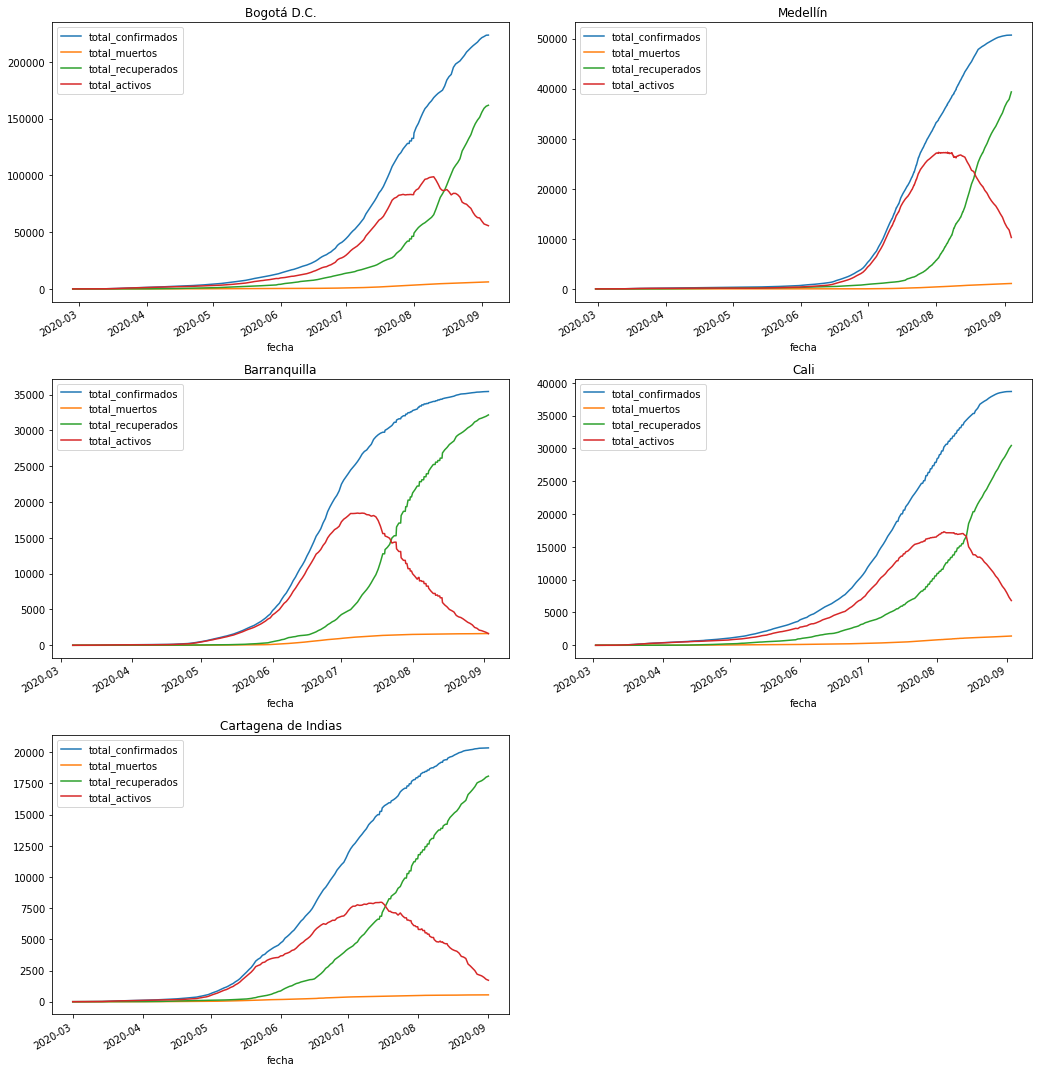

In [26]:
fig, axes = plt.subplots(3, 2,figsize=(15,15))
bogota[data_cols].plot(ax=axes[0,0]); axes[0,0].set_title('Bogotá D.C.');
medellin[data_cols].plot(ax=axes[0,1]); axes[0,1].set_title('Medellín');
barranquilla[data_cols].plot(ax=axes[1,0]); axes[1,0].set_title('Barranquilla');
cali[data_cols].plot(ax=axes[1,1]); axes[1,1].set_title('Cali');
cartagena[data_cols].plot(ax=axes[2,0]); axes[2,0].set_title('Cartagena de Indias');
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
fig.delaxes(axes[2,1])

In [27]:
## Guardar Imagen Historico
fig.savefig('Historicos.png')

# Modelos

Se crean las columnas día en los dataframes por ciudad y se saca la fecha donde se reportó el primer enfermo.

In [28]:
## Se crea la columna dia en los dataframes
medellin['dia'] = [ i+1 for i in range(len(medellin))]
bogota['dia'] = [ i+1 for i in range(len(bogota))]
barranquilla['dia'] = [ i+1 for i in range(len(barranquilla))]
cali['dia'] = [ i+1 for i in range(len(cali))]
cartagena['dia'] = [ i+1 for i in range(len(cartagena))]

In [29]:
fechamin_b = min(bogota.index).strftime("%Y-%m-%d")
fechamin_m = min(medellin.index).strftime("%Y-%m-%d")
fechamin_bll = min(barranquilla.index).strftime("%Y-%m-%d")
fechamin_c = min(cartagena.index).strftime("%Y-%m-%d")
fechamin_cl = min(cali.index).strftime("%Y-%m-%d")

## Modelo a corto Plazo

**1.** Para predecir los casos en los siguientes 5 días para cada  ciudad primero se trata de modelar con una regresión logística:

### REGRESIÓN LOGÍSTICA

En la investigación clínica y epidemiológica, en un estudio sobre enfermedades coronarias, el análisis de regresión logística es aplicado de manera común. Por esto se decide para este trabajo primero predecir con este tipo de modelo.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9f9655dad99527a46d3d532543360135b492dfd2">

Se definen las funciones para ajustar la curva a los datos reales , para predecir y graficar.

In [30]:
## Se define la funcion de Regresion logistica

def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

## Se define la funcion para ajustar la curva

def fit_logistic(dataframe, train_lim, target):

    y_data_train = dataframe.loc[(dataframe['dia'])<=train_lim,target].astype(np.int32) ## Con el tamaño de train
    x_data_train = list(range(0, len(y_data_train)))
    
    popt, pcov = curve_fit(log_curve, x_data_train, y_data_train, bounds=([0,1,0],np.inf), maxfev=500000)
    estimated_k, estimated_x_0, ymax= popt

    k = estimated_k
    x_0 = estimated_x_0
    y_fit = log_curve((range(0,train_lim)), k, x_0, ymax)
    print("k:" , k)
    print("x_0:" , x_0)
    print("ymax:" , ymax)
    
    return x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov

## Se define la funcion para graficar el ajuste y la prediccion

def plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit):
           
    y_data = dataframe[target]
    x_data = list(range(0,len(y_data)))
    
    
    x_predict = range(0,predict_limit) 
    y_predict = log_curve(x_predict, k, x_0, ymax)
    

    fig=  plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(x_data_train, y_data_train, 'g-')
    ax.plot(x_data_train, y_fit, '-')
    ax.set_xlabel("Empezando desde " + fechamin )
    ax.set_ylabel(target)
    ax.set_title("Ajuste de regresion logistica para " + ciudad)
    ax.legend(['Real', 'Ajuste'], loc='upper left')

    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(x_data, y_data, 'g-' )
    ax1.plot(x_predict,y_predict, '--')
    ax1.set_xlabel("Empezando desde " + fechamin )
    ax1.set_ylabel(target)
    ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
    ax1.legend(['Real', 'Prediccion'], loc='upper left')
    
    plt.show()

A continuación se presentan los resultados obtenidos para cada tipo de caso :

#### CONFIRMADOS

k: 0.045415261044142646
x_0: 168.6827384241783
ymax: 433192.3048973061


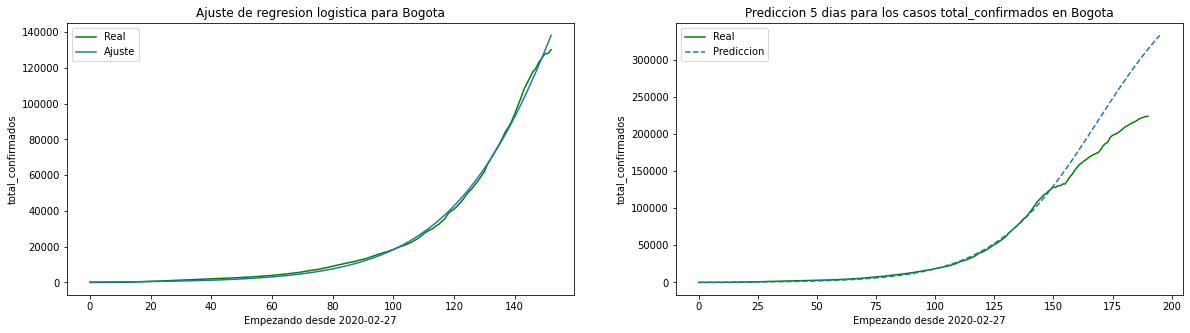

k: 0.08217190778261528
x_0: 136.55090298785498
ymax: 36526.92165239663


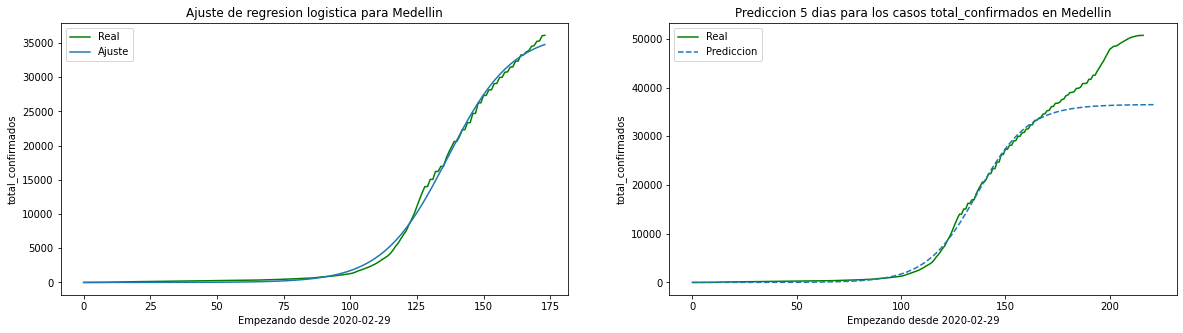

k: 0.0797804648424404
x_0: 101.65322807492116
ymax: 33522.65451615049


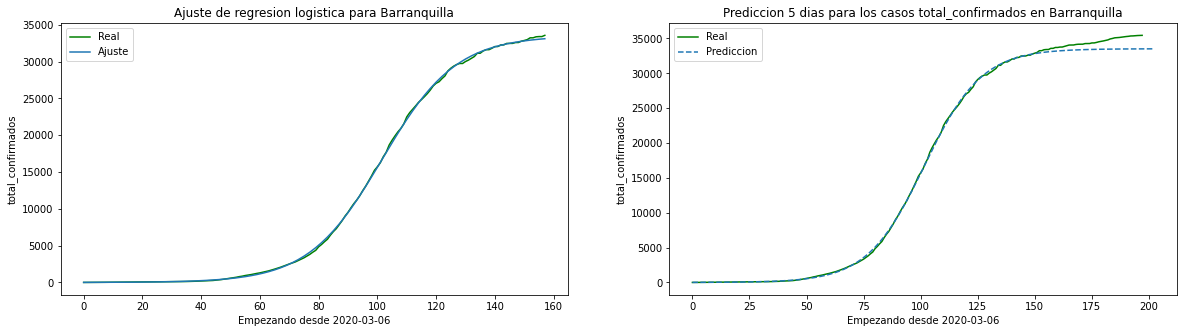

k: 0.05235813341840105
x_0: 127.8321185322821
ymax: 34030.616923231864


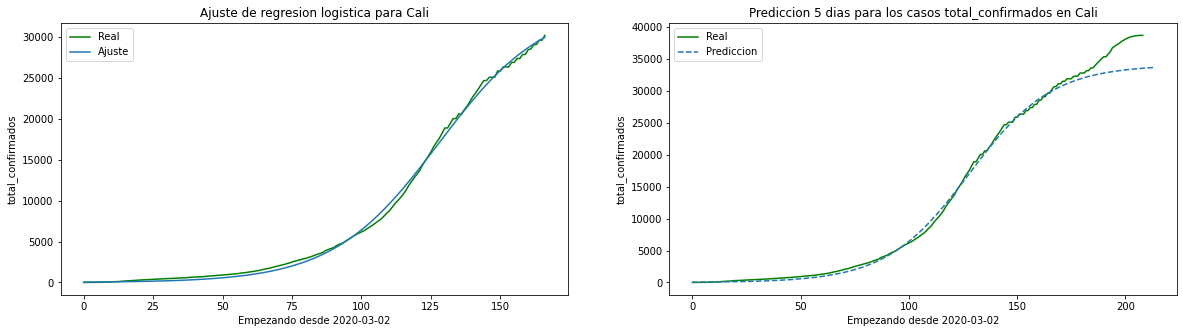

k: 0.055634755152669545
x_0: 106.24591324306901
ymax: 19260.170323958737


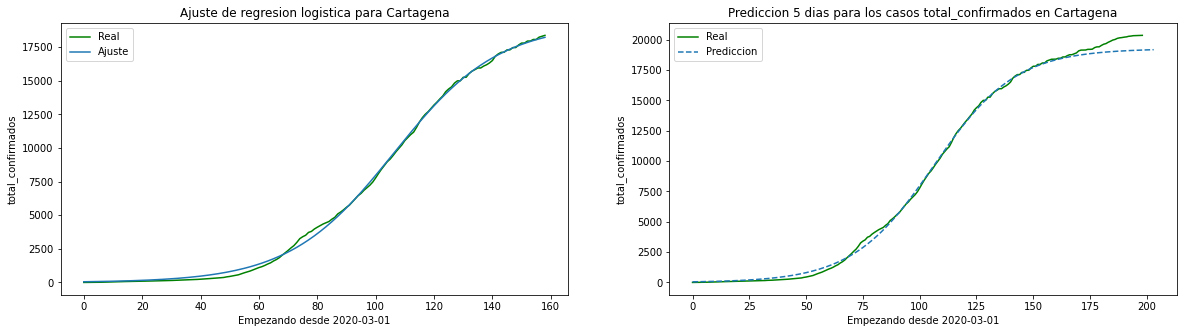

In [31]:
target = 'total_confirmados'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Bogota'
fechamin = fechamin_b


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Medellin'
fechamin = fechamin_m


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Barranquilla'
fechamin = fechamin_bll


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cali'
fechamin = fechamin_cl


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cartagena'
fechamin = fechamin_c


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)

#### ACTIVOS

k: 0.051939742934223064
x_0: 151.00163892445198
ymax: 179303.2977529


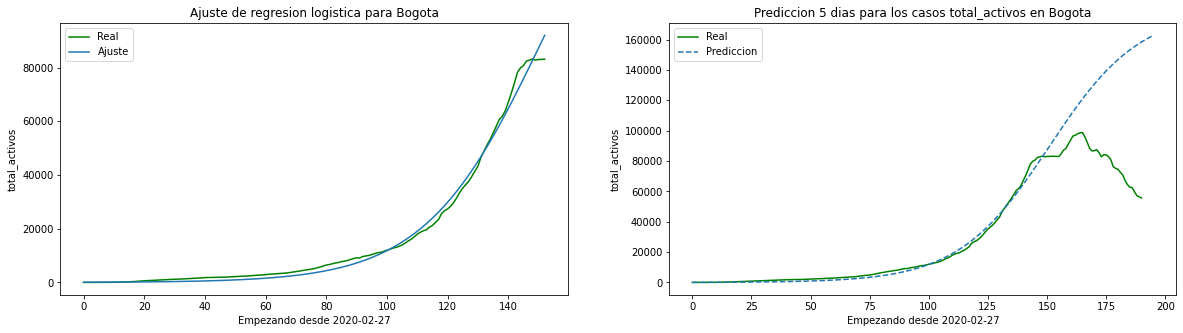

k: 0.10158210749391902
x_0: 132.07027785035456
ymax: 27703.596508126295


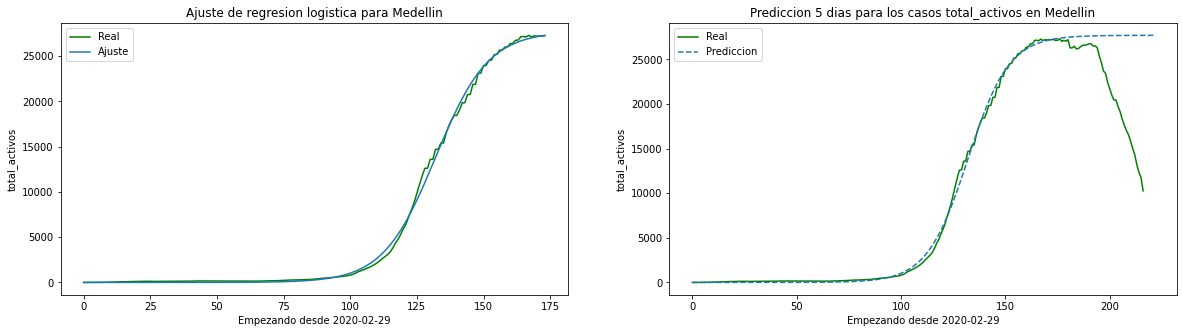

k: 0.15372493833085735
x_0: 86.33544624659372
ymax: 14355.741885169593


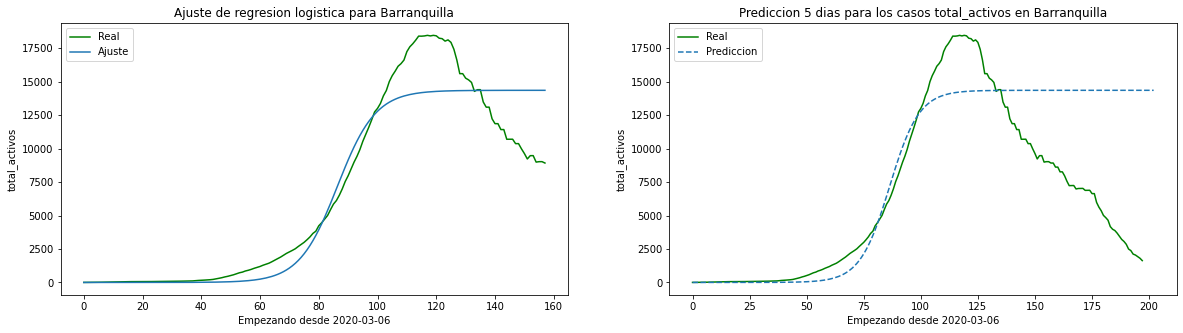

k: 0.05774235936081933
x_0: 120.2238166838372
ymax: 18949.22258457801


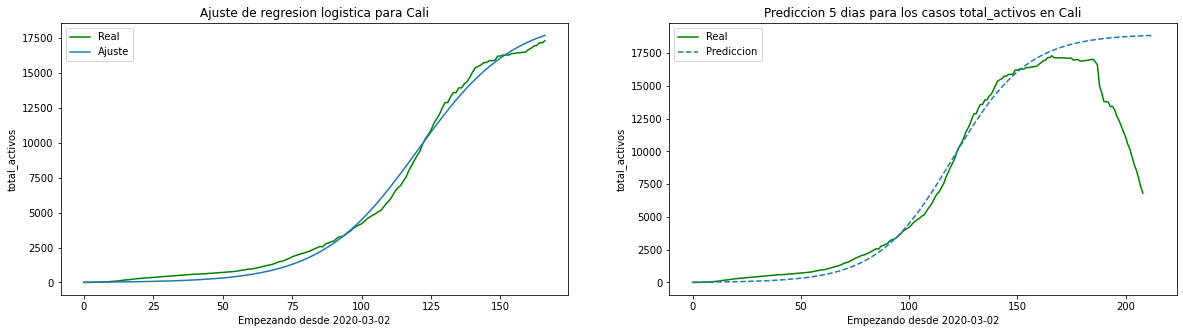

k: 0.08552133131786577
x_0: 82.67561610268639
ymax: 7142.126021301815


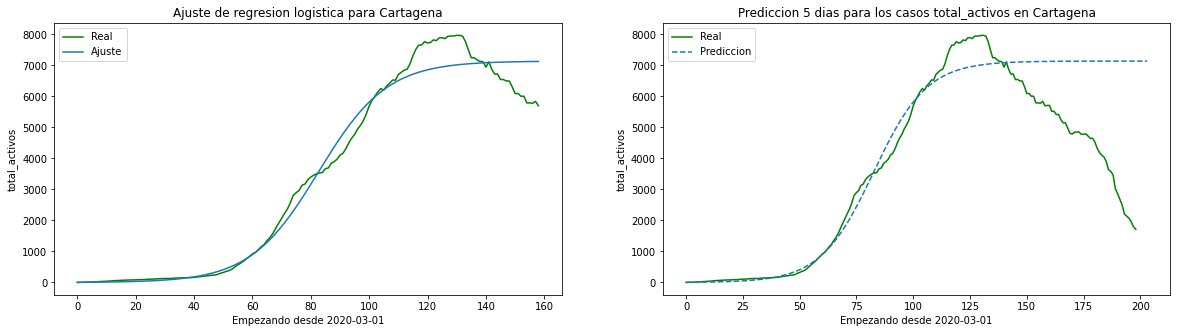

In [32]:
target = 'total_activos'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)

ciudad = 'Bogota'
fechamin = fechamin_b
x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Medellin'
fechamin = fechamin_m


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Barranquilla'
fechamin = fechamin_bll


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cali'
fechamin = fechamin_cl


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cartagena'
fechamin = fechamin_c


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)

#### RECUPERADOS

k: 0.039172285872717816
x_0: 465.1917882041676
ymax: 9011966854.829664


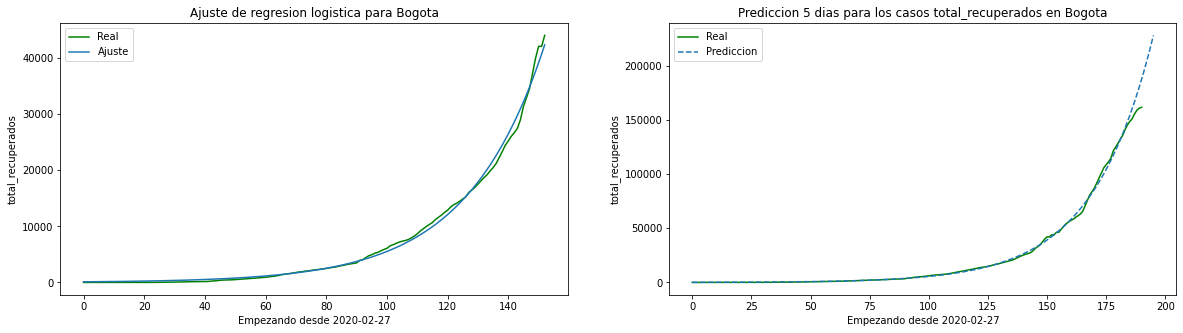

k: 0.04218510002059961
x_0: 473.3902368702427
ymax: 2638140463.292992


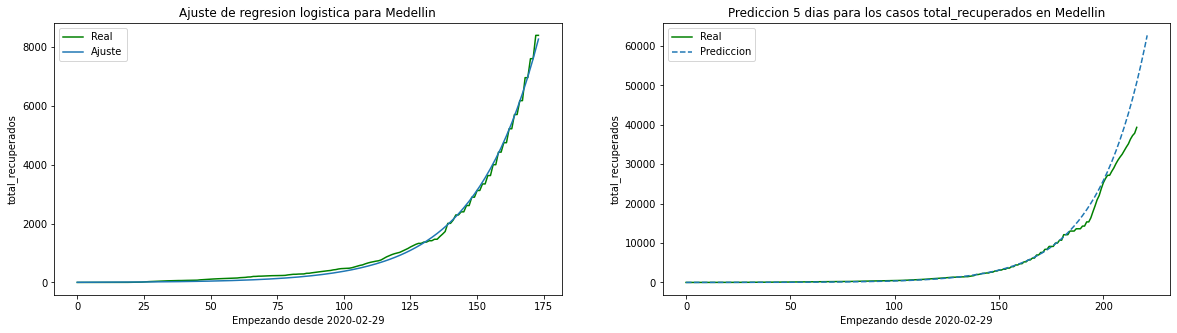

k: 0.08520526400287945
x_0: 129.5852812254879
ymax: 25587.272617705545


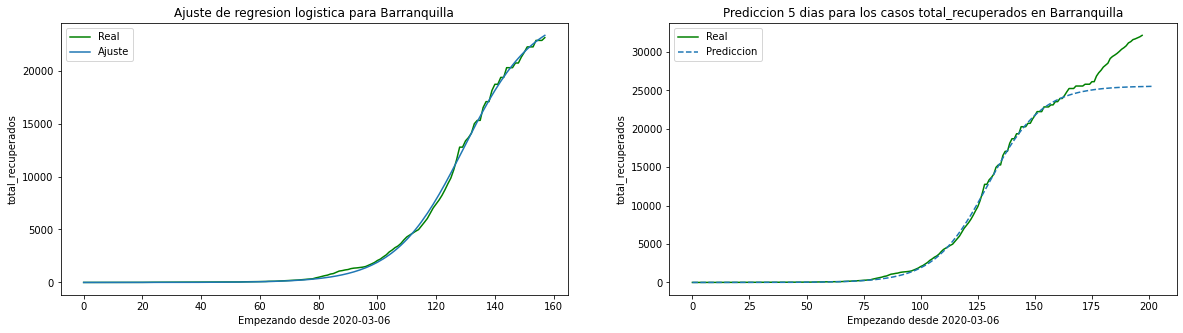

k: 0.046767239714579474
x_0: 144.8944949982829
ymax: 16165.518332828155


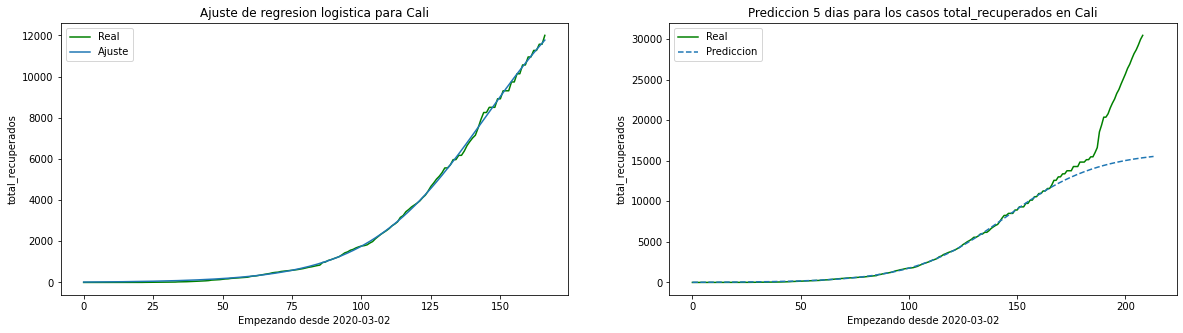

k: 0.0582895293763902
x_0: 131.5252698293444
ymax: 14759.265241266598


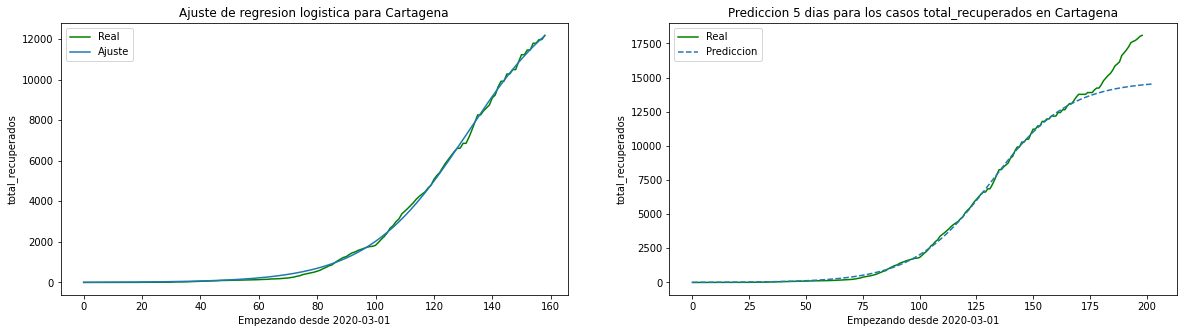

In [33]:
target = 'total_recuperados'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Bogota'
fechamin = fechamin_b


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Medellin'
fechamin = fechamin_m


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Barranquilla'
fechamin = fechamin_bll


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cali'
fechamin = fechamin_cl


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cartagena'
fechamin = fechamin_c


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)

#### MUERTOS

k: 0.042678663120815884
x_0: 443.2963210882295
ymax: 806377011.4845108


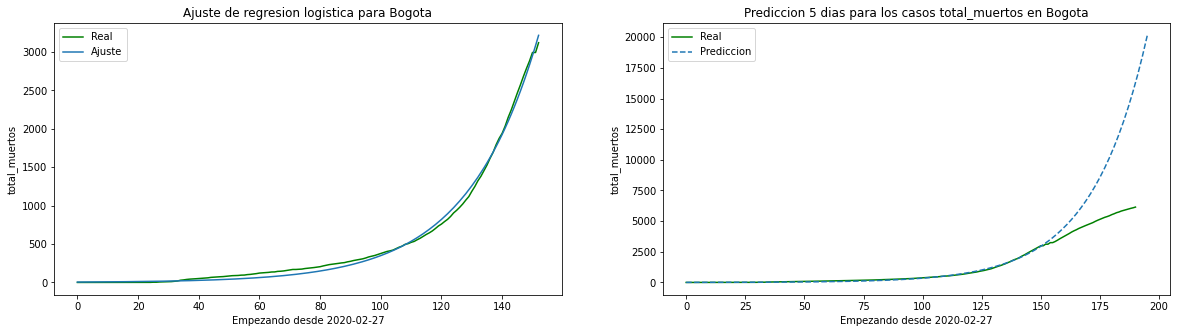

k: 0.0758268394887696
x_0: 152.73441963001346
ymax: 565.0907915776893


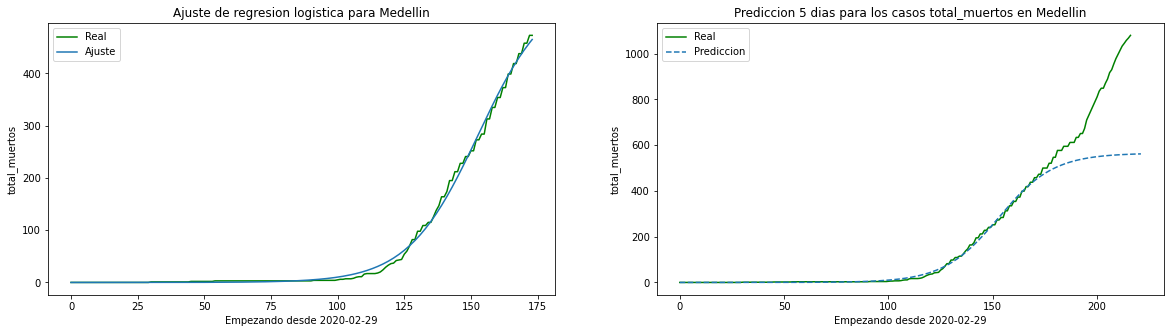

k: 0.0910676032730905
x_0: 104.0677567749262
ymax: 1536.0871261599261


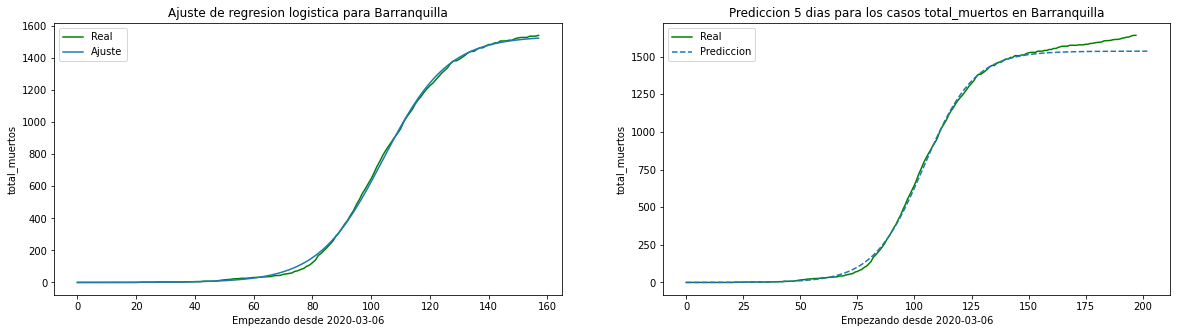

k: 0.038390585652981014
x_0: 150.3611442836211
ymax: 1416.0594005699404


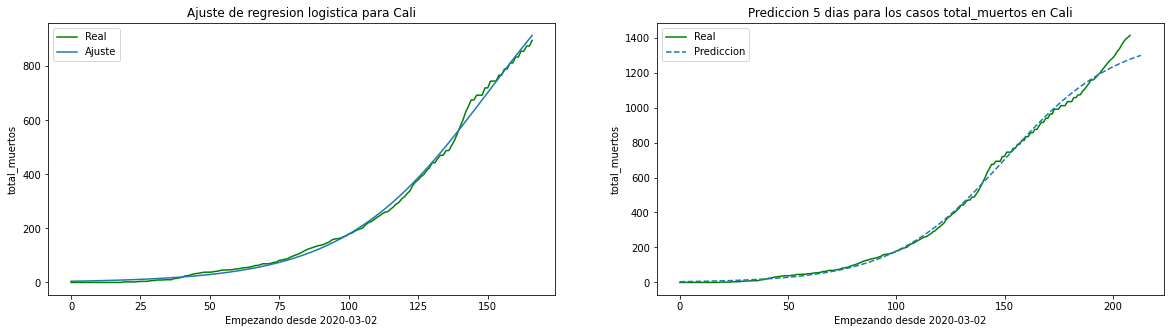

k: 0.055389711405960745
x_0: 98.12800553857916
ymax: 517.0647850249392


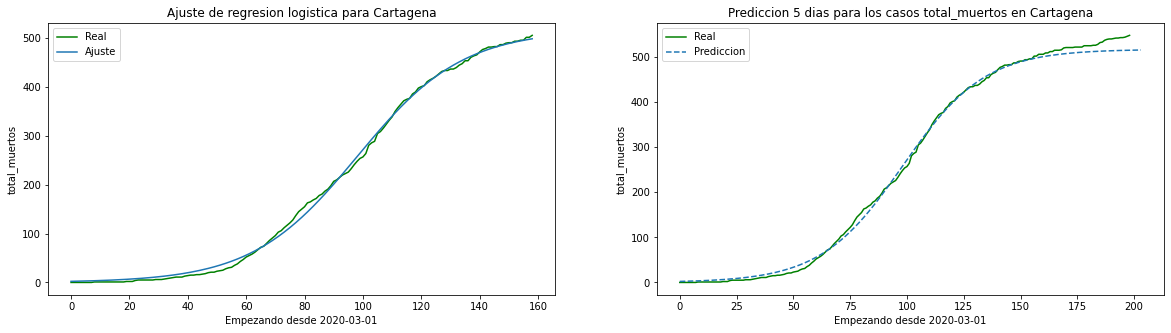

In [34]:
target = 'total_muertos'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Bogota'
fechamin = fechamin_b


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Medellin'
fechamin = fechamin_m


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Barranquilla'
fechamin = fechamin_bll


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cali'
fechamin = fechamin_cl


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)


## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
predict_limit = len(dataframe) + 5 ## Dias a predecir (dias historicos + 5)
ciudad = 'Cartagena'
fechamin = fechamin_c


x_data_train, y_data_train, y_fit, (k, x_0, ymax), pcov = fit_logistic(dataframe, train_lim, target)
plot_logistic(dataframe, ciudad, x_data_train, y_data_train, y_fit, target , fechamin , x_0, ymax ,k , predict_limit)

**CONCLUSIONES REGRESIÓN LOGÍSTICA**

Con estos resultados se concluye que este puede ser un modelo bueno para los casos confirmados , recuperados y muertos para la mayoría de las ciudades.

Para los casos activos no se observa un buen ajuste ni predicción ya que según los datos históricos vemos un comportamiento de campana, por este motivo se decide probar con un modelo ARIMA.

**2.** Se hace el ajuste y pronóstico con un modelo ARIMA:

### ARIMA

<p style='text-align: justify;'>ARIMA, abreviatura de 'Media móvil integrada auto regresiva' es en realidad una clase de modelos que 'explica' una serie de tiempo determinada en función de sus propios valores pasados, es decir, sus propios retrasos y los errores de pronóstico retrasados, de modo que se puede utilizar la ecuación para pronosticar valores futuros.</p>

Cualquier serie de tiempo "no estacional" que muestre patrones y no sea un ruido blanco aleatorio se puede modelar con modelos ARIMA.

Un modelo ARIMA se caracteriza por 3 términos: p, d, q

dónde,

p es el orden del término AR

q es el orden del término MA

d es el número de diferenciaciones necesarias para que la serie temporal sea estacionaria

<img src="https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-4-min.png">

Se definen las funciones para definir el set de train y test , para elegir los mejores parámetros p,d y q del modelo y así predecir los siguientes 5 días por cada tipo de caso

In [35]:
## Partir el dataframe en test y train

def split(dataframe,target,train_lim):

    data = dataframe[target]
    train = data.values[:train_lim]
    test =  data.values[train_lim:]

    return(train,test,data)

def arima(dataframe,train,test):
    
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    ## Determinar los mejores parametros
    for var in pdq:
        try:
            model = ARIMA(train, order=var)
            result = model.fit()

            if (result.aic<=a):
                a=result.aic
                param=var
        except:
            continue
            
    ## Modelo
    model = ARIMA(train, order=param)
    result = model.fit(disp=-1)
   
    ## Prediccion
    predict_lim = (len(test)+ 5)
    fc, se, conf = result.forecast(predict_lim, alpha=0.05)  # 95% conf
    
    ## Convertir a serie
    
    index = list(range(len(train),len(train) + predict_lim))
    index2 = list(range(len(train),len(dataframe)))
    fc_series = pd.Series(fc, index=index)
    lower_series = pd.Series(conf[:, 0], index=index)
    upper_series = pd.Series(conf[:, 1], index=index)
    test_series = pd.Series(test, index=index2)
    
    return (fc_series,lower_series,upper_series,test_series)


A continuación se presentan los resultados obtenidos para cada tipo de caso :

#### CONFIRMADOS

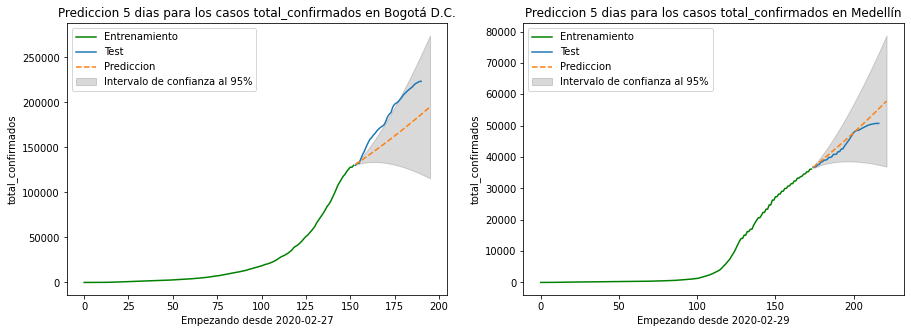

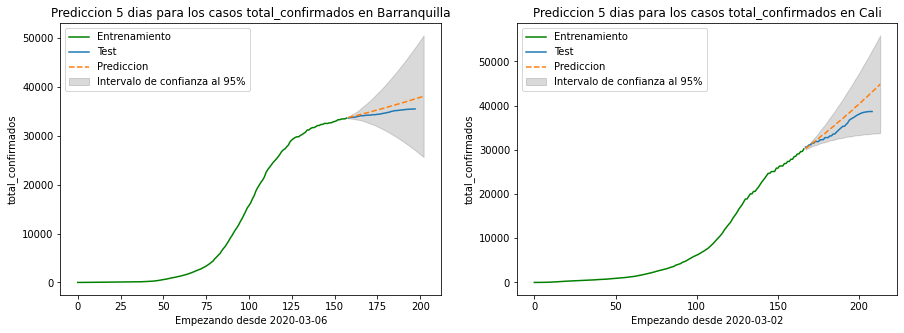

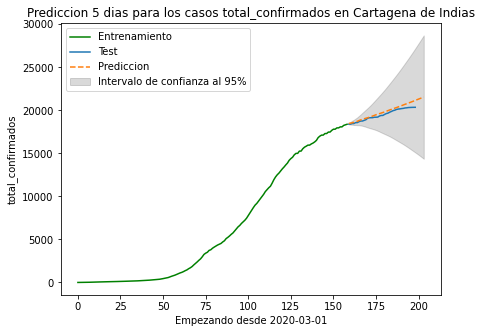

In [36]:
target = 'total_confirmados'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Bogotá D.C.'
fechamin = fechamin_b

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Medellín'
fechamin = fechamin_m

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_confirmados_mb.png')

## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Barranquilla'
fechamin = fechamin_bll

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos "+ target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cali'
fechamin = fechamin_cl

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_confirmados_bllcl.png')

## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cartagena de Indias'
fechamin = fechamin_c

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_confirmados_c.png')


#### ACTIVOS

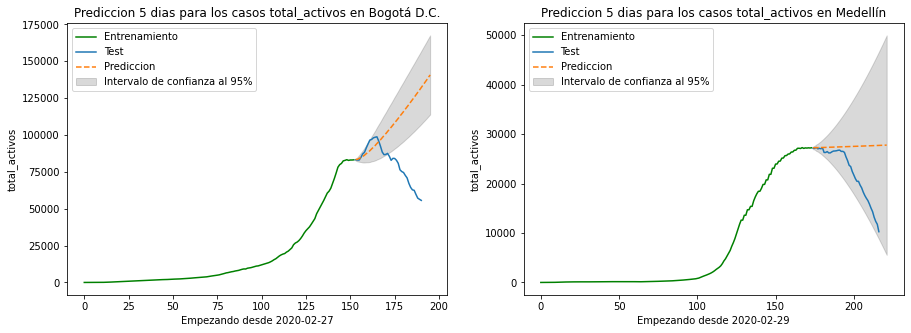

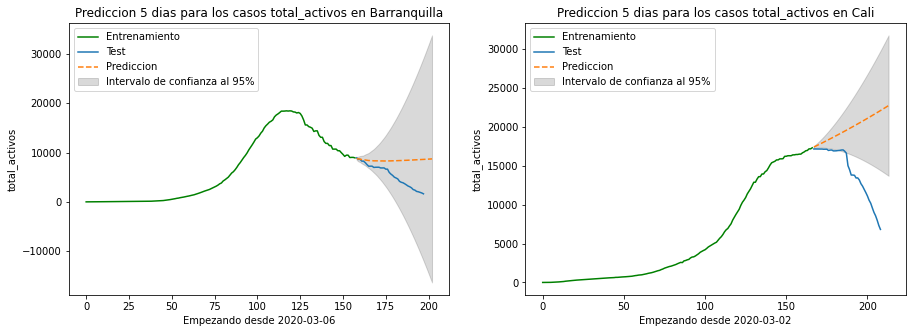

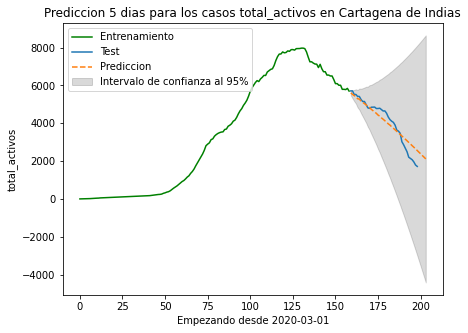

In [37]:
target = 'total_activos'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Bogotá D.C.'
fechamin = fechamin_b

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Medellín'
fechamin = fechamin_m

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_activos_mb.png')

## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Barranquilla'
fechamin = fechamin_bll

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos "+ target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cali'
fechamin = fechamin_cl

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_activos_bllcl.png')

## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cartagena de Indias'
fechamin = fechamin_c

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_activos_c.png')

#### RECUPERADOS

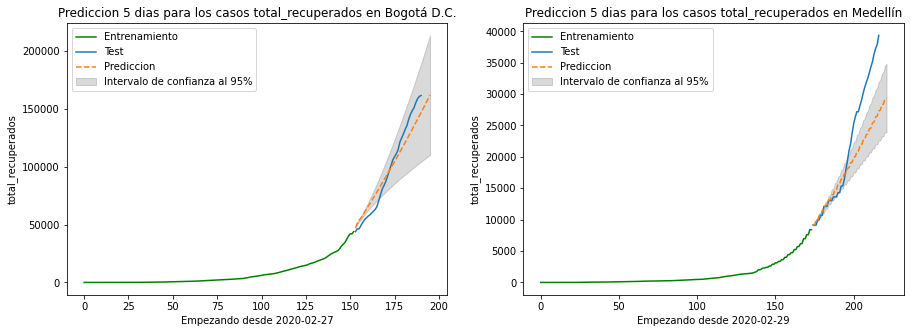

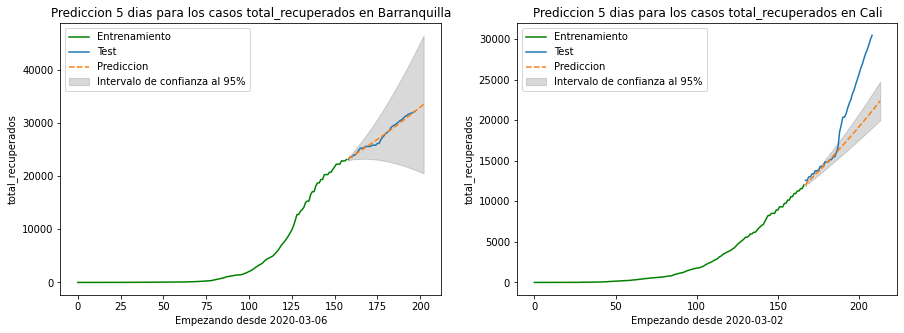

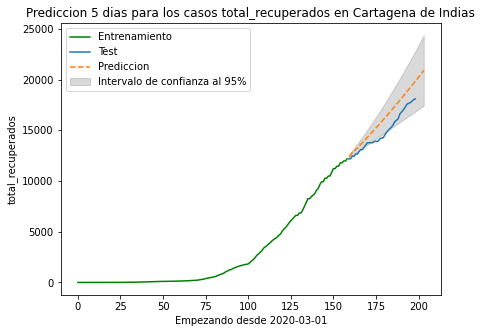

In [38]:
target = 'total_recuperados'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Bogotá D.C.'
fechamin = fechamin_b

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Medellín'
fechamin = fechamin_m

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_recuperados_mb.png')

## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Barranquilla'
fechamin = fechamin_bll

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos "+ target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cali'
fechamin = fechamin_cl

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_recuperados_bllcl.png')

## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cartagena de Indias'
fechamin = fechamin_c

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_recuperados_c.png')

#### MUERTOS

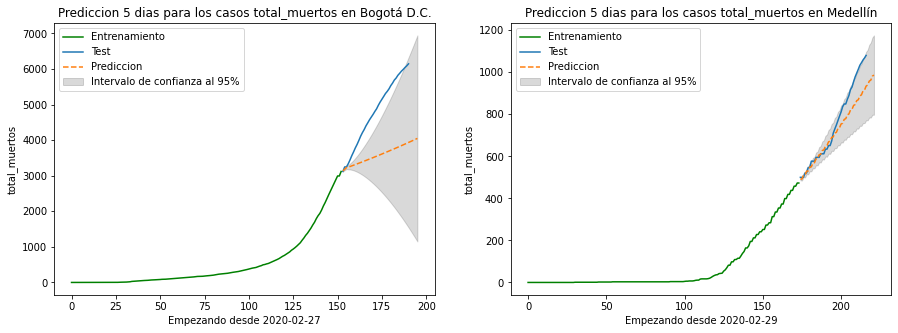

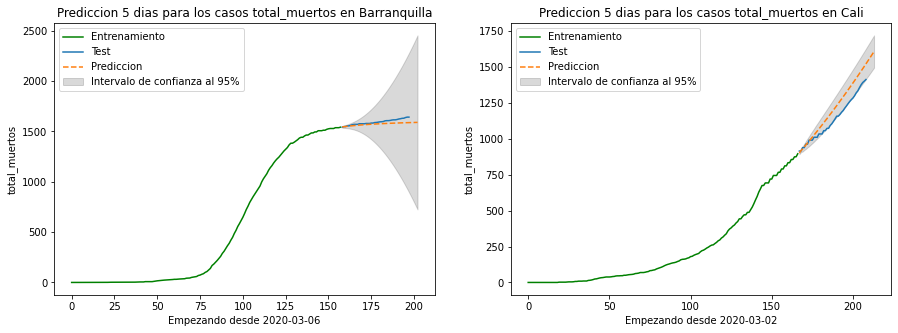

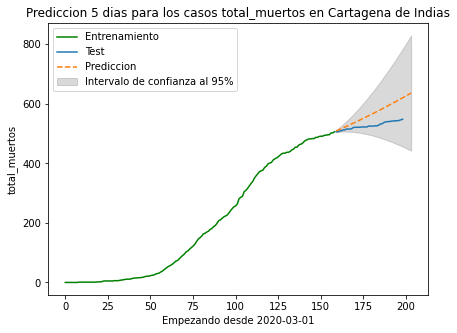

In [39]:
target = 'total_muertos'

## Bogota
dataframe= bogota
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Bogotá D.C.'
fechamin = fechamin_b

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Medellin
dataframe= medellin
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Medellín'
fechamin = fechamin_m

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_muertos_mb.png')

## Barranquilla
dataframe= barranquilla
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Barranquilla'
fechamin = fechamin_bll

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos "+ target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Cali
dataframe= cali
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cali'
fechamin = fechamin_cl

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

ax1 = fig.add_subplot (1,2,2)
ax1.plot(train, 'g-')
ax1.plot(test_series, '-')
ax1.plot(fc_series, '--')
ax1.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax1.set_xlabel("Empezando desde " + fechamin )
ax1.set_ylabel(target)
ax1.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax1.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_muertos_bllcl.png')

## Cartagena
dataframe= cartagena
train_lim = round(len(dataframe)*0.8) ## Limite de dias para ajustar la curva (80% de el total de los dias historicos)
ciudad = 'Cartagena de Indias'
fechamin = fechamin_c

train,test,data =  split(dataframe,target,train_lim)
fc_series,lower_series,upper_series,test_series =arima(dataframe,train,test)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train, 'g-')
ax.plot(test_series, '-')
ax.plot(fc_series, '--')
ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
ax.set_xlabel("Empezando desde " + fechamin )
ax.set_ylabel(target)
ax.set_title("Prediccion 5 dias para los casos " + target + " en " + ciudad)
ax.legend(['Entrenamiento', 'Test' , 'Prediccion' , 'Intervalo de confianza al 95%'], loc='upper left')

## Guardar Imagen
fig.savefig('ARIMA_muertos_c.png')

**CONCLUSIONES MODELO ARIMA**

A partir de los gráfico, el modelo ARIMA parecen dar un pronóstico direccionalmente correcto en su mayoría , donde los valores reales observados se encuentran dentro de la banda de confianza del 95%.

Por este motivo se decide quedar con este modelo para la predicción a corto plazo.

## Modelo a largo Plazo

### MODELO SIR

**SIR** es un modelo simple que considera una población que pertenece a uno de los siguientes estados:

<p style='text-align: justify;'> Susceptible (S):  Las personas que no han contraído la enfermedad, pero puede infectarse debido a la transmisión de personas infectadas. </p>

<p style='text-align: justify;'>Infectado (I): Estas personas han contraído la enfermedad.</p>

<p style='text-align: justify;'>Recuperado / Fallecido (R): La enfermedad puede llevar a uno de dos destinos: o la persona sobrevive, desarrollando inmunidad a la enfermedad, o la persona ha fallecido.</p>

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png">

**1.** Se procede a calcular las tasas de contagio y recuperación ajustando los parámetros con el histórico de total de casos activos por ciudad.

Para la tasa de muerte se definió una de 0.002 según la observado en los datos históricos.

In [40]:
## Se Crea la funcion para obtener los datos por ciudad
def ciudad(dataframe, target):
    
    poblacion = dataframe.iloc[1,1]
    df = dataframe[['dia',target]]
    
    ydata = [i for i in df.iloc[:,1]]
    xdata = df.dia
    
    ydata = np.array(ydata, dtype=float)
    xdata = np.array(xdata, dtype=float)
    
    N = poblacion
    inf0 = ydata[0]
    sus0 = N - inf0
    rec0 = 0

    return ydata,xdata,N,inf0,sus0,rec0


## Se define la funcion de el modelo SIR

def sir_model(ydata, xdata, beta, gamma):
    sus = -beta * ydata[0] * ydata[1] / N
    rec = gamma * ydata[1]
    inf = -(sus + rec)
    return sus, inf, rec


## Se define la funcion para derivar

def fit_odeint(xdata, beta, gamma):
    return odeint(sir_model, (sus0, inf0, rec0), xdata, args=(beta, gamma))[:,1]



Optimal parameters: beta = 0.43992871392505895  and gamma =  0.3712991283825589
Optimal parameters: beta = 0.5268833890660983  and gamma =  0.4457683324049266
Optimal parameters: beta = 0.4981801261878732  and gamma =  0.4099088283208788
Optimal parameters: beta = 0.5446365165594813  and gamma =  0.47510322097248303
Optimal parameters: beta = 0.60792082458415  and gamma =  0.5277163900849979


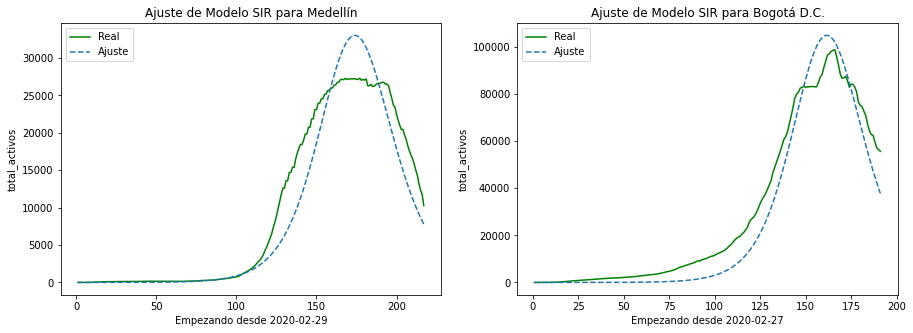

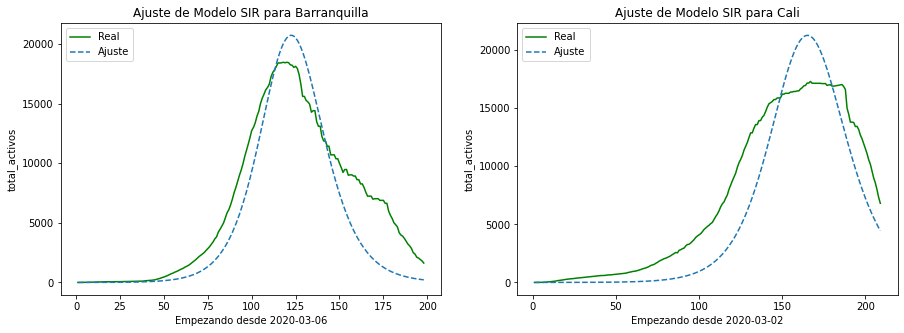

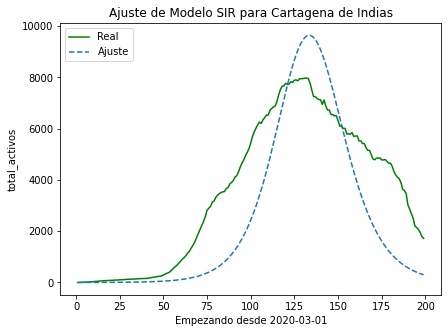

In [41]:
## Se crea Dataframe para guardar las tasas

cols = ['ciudad','tasa_contagio','tasa_recuperacion' ]

filas = []

target = 'total_activos'


## Medellin
dataframe = medellin
fechamin = fechamin_m
ciudadn = 'Medellín'

ydata,xdata,N,inf0,sus0,rec0 = ciudad(dataframe, target)
popt, pcov = curve_fit(fit_odeint, xdata, ydata,maxfev = 50000000)
fitted = fit_odeint(xdata, *popt)
beta =  popt[0]
gamma = popt[1]
print("Optimal parameters: beta =", beta, " and gamma = ", gamma)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(xdata, ydata, 'g-')
ax.plot(xdata, fitted , '--')
ax.set_title("Ajuste de Modelo SIR para " + ciudadn)
ax.set_ylabel(target)
ax.set_xlabel("Empezando desde " + fechamin)
ax.legend(['Real', 'Ajuste'], loc='upper left')

tasa_m = pd.DataFrame(filas, columns=cols ,index =['0'])
tasa_m['ciudad']= ciudadn
tasa_m['tasa_contagio'] = beta
tasa_m['tasa_recuperacion'] =gamma

## Bogota
dataframe = bogota
fechamin = fechamin_b
ciudadn = 'Bogotá D.C.'

ydata,xdata,N,inf0,sus0,rec0 = ciudad(dataframe, target)
popt, pcov = curve_fit(fit_odeint, xdata, ydata,maxfev = 50000000)
fitted = fit_odeint(xdata, *popt)
beta =  popt[0]
gamma = popt[1]
print("Optimal parameters: beta =", beta, " and gamma = ", gamma)

ax1 = fig.add_subplot(1,2,2)
ax1.plot(xdata, ydata, 'g-')
ax1.plot(xdata, fitted , '--')
ax1.set_title("Ajuste de Modelo SIR para " + ciudadn)
ax1.set_ylabel(target)
ax1.set_xlabel("Empezando desde " + fechamin)
ax1.legend(['Real', 'Ajuste'], loc='upper left')

tasa_b = pd.DataFrame(filas, columns=cols ,index =['0'])
tasa_b['ciudad']= ciudadn
tasa_b['tasa_contagio'] = beta
tasa_b['tasa_recuperacion'] =gamma


## Barranquilla
dataframe = barranquilla
fechamin = fechamin_bll
ciudadn = 'Barranquilla'

ydata,xdata,N,inf0,sus0,rec0 = ciudad(dataframe, target)
popt, pcov = curve_fit(fit_odeint, xdata, ydata,maxfev = 50000000)
fitted = fit_odeint(xdata, *popt)
beta =  popt[0]
gamma = popt[1]
print("Optimal parameters: beta =", beta, " and gamma = ", gamma)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(xdata, ydata, 'g-')
ax.plot(xdata, fitted , '--')
ax.set_title("Ajuste de Modelo SIR para " + ciudadn)
ax.set_ylabel(target)
ax.set_xlabel("Empezando desde " + fechamin)
ax.legend(['Real', 'Ajuste'], loc='upper left')

tasa_bll = pd.DataFrame(filas, columns=cols ,index =['0'])
tasa_bll['ciudad']= ciudadn
tasa_bll['tasa_contagio'] = beta
tasa_bll['tasa_recuperacion'] =gamma

## Cali
dataframe = cali
fechamin = fechamin_cl
ciudadn = 'Cali'

ydata,xdata,N,inf0,sus0,rec0 = ciudad(dataframe, target)
popt, pcov = curve_fit(fit_odeint, xdata, ydata,maxfev = 50000000)
fitted = fit_odeint(xdata, *popt)
beta =  popt[0]
gamma = popt[1]
print("Optimal parameters: beta =", beta, " and gamma = ", gamma)

ax1 = fig.add_subplot(1,2,2)
ax1.plot(xdata, ydata, 'g-')
ax1.plot(xdata, fitted , '--')
ax1.set_title("Ajuste de Modelo SIR para " + ciudadn)
ax1.set_ylabel(target)
ax1.set_xlabel("Empezando desde " + fechamin)
ax1.legend(['Real', 'Ajuste'], loc='upper left')

tasa_cl = pd.DataFrame(filas, columns=cols ,index =['0'])
tasa_cl['ciudad']= ciudadn
tasa_cl['tasa_contagio'] = beta
tasa_cl['tasa_recuperacion'] =gamma

## Cartagena
dataframe = cartagena
fechamin = fechamin_c
ciudadn = 'Cartagena de Indias'

ydata,xdata,N,inf0,sus0,rec0 = ciudad(dataframe, target)
popt, pcov = curve_fit(fit_odeint, xdata, ydata,maxfev = 50000000)
fitted = fit_odeint(xdata, *popt)
beta =  popt[0]
gamma = popt[1]
print("Optimal parameters: beta =", beta, " and gamma = ", gamma)

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(xdata, ydata, 'g-')
ax.plot(xdata, fitted , '--')
ax.set_title("Ajuste de Modelo SIR para " + ciudadn)
ax.set_ylabel(target)
ax.set_xlabel("Empezando desde " + fechamin)
ax.legend(['Real', 'Ajuste'], loc='upper left')

tasa_c = pd.DataFrame(filas, columns=cols ,index =['0'])
tasa_c['ciudad']= ciudadn
tasa_c['tasa_contagio'] = beta
tasa_c['tasa_recuperacion'] =gamma


In [42]:
## Concatenar las tasas de cada ciudad
tasa = pd.concat([tasa_m,tasa_cl,tasa_c,tasa_b,tasa_bll])
tasa = tasa.reset_index(drop=True)
tasa['tasa_muerte'] = [0.002 , 0.001 , 0.002 , 0.002, 0.002]
tasa

,ciudad,tasa_contagio,tasa_recuperacion,tasa_muerte
0,Medellín,0.439929,0.371299,0.002
1,Cali,0.544637,0.475103,0.001
2,Cartagena de Indias,0.607921,0.527716,0.002
3,Bogotá D.C.,0.526883,0.445768,0.002
4,Barranquilla,0.498180,0.409909,0.002


**2.** Se crea una tabla maestra desde la fecha mínima donde se encontró el primer caso , hasta 20 días después de la fecha actual por ciudad , donde se harán los cálculos del modelo SIR.

In [43]:
## Sacar fecha de pronostico por ciudad

fechamax = (datetime.now() + timedelta(20)).strftime("%Y-%m-%d")

In [44]:
## Se crea dataframe por ciudad y luego se concantenan

cols = ['fecha','ciudad', 'poblacion_suceptible_sir','activos_sir' ,'casos_nuevos_sir',
       'recuperados_sir', 'muertos_sir' ,'total_confirmados_sir','total_recuperados_sir','total_muertos_sir','total_activos_sir' ]

filas = []


## Datos Bogota
data_b = pd.DataFrame(filas, columns=cols)     
fechas_b = pd.date_range(fechamin_b,fechamax).tolist()
data_b['fecha'] = fechas_b
data_b['ciudad'] = 'Bogotá D.C.'

## Datos Barranquilla
data_bll = pd.DataFrame(filas, columns=cols)   
fechas_bll = pd.date_range(fechamin_bll,fechamax).tolist()
data_bll['fecha'] = fechas_bll
data_bll['ciudad'] = 'Barranquilla'

## Datos Cartagena
data_c = pd.DataFrame(filas, columns=cols)  
fechas_c = pd.date_range(fechamin_c,fechamax).tolist()
data_c['fecha'] = fechas_c
data_c['ciudad'] = 'Cartagena de Indias'


## Datos Cali
data_cl = pd.DataFrame(filas, columns=cols)  
fechas_cl = pd.date_range(fechamin_cl,fechamax).tolist()
data_cl['fecha'] = fechas_cl
data_cl['ciudad'] = 'Cali'

## Datos Medellin}
data_m = pd.DataFrame(filas, columns=cols)  
fechas_m = pd.date_range(fechamin_m,fechamax).tolist()
data_m['fecha'] = fechas_m
data_m['ciudad'] = 'Medellín'

## Se concatenan los dataframes por ciudad
consolidado = pd.concat([data_m,data_cl,data_c,data_b,data_bll])

## Se trae la poblacion total por ciudad
consolidado =  pd.merge(consolidado, poblacion, on=['ciudad'], how='inner')

## Se trae el promedio de tasas por ciudad
consolidado =  pd.merge(consolidado, tasa, on=['ciudad'], how='inner')

## Se ordena el dataframe
consolidado = consolidado[['fecha','ciudad', 'poblacion', 'poblacion_suceptible_sir','total_confirmados_sir','total_recuperados_sir',
                           'total_muertos_sir','total_activos_sir','activos_sir','casos_nuevos_sir', 'recuperados_sir', 'muertos_sir','tasa_contagio',
                           'tasa_recuperacion','tasa_muerte']]

## Llevar al index las fechas
consolidado = consolidado.set_index('fecha')

## Se ordena el set de datos por ciudad y fecha
consolidado = consolidado.sort_values(by=['ciudad', 'fecha' ])

## Se reemplazan los nulos por cero
consolidado = consolidado.fillna(value='0')

consolidado

,ciudad,poblacion,poblacion_suceptible_sir,total_confirmados_sir,total_recuperados_sir,total_muertos_sir,total_activos_sir,activos_sir,casos_nuevos_sir,recuperados_sir,muertos_sir,tasa_contagio,tasa_recuperacion,tasa_muerte
fecha,,,,,,,,,,,,,,
2020-03-06,Barranquilla,1239804,0,0,0,0,0,0,0,0,0,0.498180,0.409909,0.002
2020-03-07,Barranquilla,1239804,0,0,0,0,0,0,0,0,0,0.498180,0.409909,0.002
2020-03-08,Barranquilla,1239804,0,0,0,0,0,0,0,0,0,0.498180,0.409909,0.002
2020-03-09,Barranquilla,1239804,0,0,0,0,0,0,0,0,0,0.498180,0.409909,0.002
2020-03-10,Barranquilla,1239804,0,0,0,0,0,0,0,0,0,0.498180,0.409909,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,Medellín,2569007,0,0,0,0,0,0,0,0,0,0.439929,0.371299,0.002
2020-09-24,Medellín,2569007,0,0,0,0,0,0,0,0,0,0.439929,0.371299,0.002
2020-09-25,Medellín,2569007,0,0,0,0,0,0,0,0,0,0.439929,0.371299,0.002


In [45]:
## Pasar las columnas numericas a int
consolidado['poblacion_suceptible_sir'] = consolidado['poblacion_suceptible_sir'].apply(int)
consolidado['casos_nuevos_sir'] = consolidado['casos_nuevos_sir'].apply(int)
consolidado['recuperados_sir'] = consolidado['recuperados_sir'].apply(int)
consolidado['muertos_sir'] = consolidado['muertos_sir'].apply(int)
consolidado['total_confirmados_sir'] = consolidado['total_confirmados_sir'].apply(int)
consolidado['total_recuperados_sir'] = consolidado['total_recuperados_sir'].apply(int)
consolidado['total_muertos_sir'] = consolidado['total_muertos_sir'].apply(int)
consolidado['total_activos_sir'] = consolidado['total_activos_sir'].apply(int)


**3.** Se hacen los cálculos del Modelo SIR para así predecir los siguientes 20 días después de la fecha actual.

In [46]:
consolidado_sir = consolidado.copy()

for i in range(len(consolidado_sir)):
    
    ciudad= consolidado_sir.iloc[i,0]
    
    if i >0 and ciudad == consolidado_sir.iloc[i-1,0]:
       
        consolidado_sir.iloc[i,9] =  consolidado_sir.iloc[i-1,7]*consolidado_sir.iloc[i,12] ## Recuperados
        consolidado_sir.iloc[i,10] =  consolidado_sir.iloc[i-1,7]*consolidado_sir.iloc[i,13] ## Muertos
        
        if consolidado_sir.iloc[i-1,3] >= consolidado_sir.iloc[i,1] : ## Si los tolates confirmados >= Poblacion total
            
            consolidado_sir.iloc[i,8] = 0 ## Casos nuevos
        
        else:
            
            consolidado_sir.iloc[i,8] = ((consolidado_sir.iloc[i,11] * consolidado_sir.iloc[i-1,7] * consolidado_sir.iloc[i-1,2])/(consolidado_sir.iloc[i,1])) ## Casos nuevos
        
        consolidado_sir.iloc[i,7] = consolidado_sir.iloc[i-1,7] + consolidado_sir.iloc[i,8] - consolidado_sir.iloc[i,9] - consolidado_sir.iloc[i,10]  ## Activos
            
        consolidado_sir.iloc[i,2] = round(consolidado_sir.iloc[i-1,2] - consolidado_sir.iloc[i,8],2)  ## Poblacion suceptible
        consolidado_sir.iloc[i,3] = consolidado_sir.iloc[i-1,3] + consolidado_sir.iloc[i,8]  ## Total confirmados
        consolidado_sir.iloc[i,4] = consolidado_sir.iloc[i-1,4] + consolidado_sir.iloc[i,9]  ## Total recuperados
        consolidado_sir.iloc[i,5] = consolidado_sir.iloc[i-1,5] + consolidado_sir.iloc[i,10] ## Total muertos
        consolidado_sir.iloc[i,6] = consolidado_sir.iloc[i,7] ## Total activos
    
    else:
        
        consolidado_sir.iloc[i,8] = 1 ## Casos nuevos
        consolidado_sir.iloc[i,7] = 1 ## Activos
        consolidado_sir.iloc[i,2] = round(consolidado_sir.iloc[i,1] - 1,2)  ## Poblacion suceptible
        consolidado_sir.iloc[i,3] = 1 ## Total confirmados
        consolidado_sir.iloc[i,6] = 1 ## Total activos

In [47]:
## Se separa el dataframe por ciudad
medellin_sir = consolidado_sir[consolidado_sir['ciudad'] == 'Medellín']
bogota_sir = consolidado_sir[consolidado_sir['ciudad'] == 'Bogotá D.C.']
barranquilla_sir = consolidado_sir[consolidado_sir['ciudad'] == 'Barranquilla']
cali_sir = consolidado_sir[consolidado_sir['ciudad'] == 'Cali']
cartagena_sir = consolidado_sir[consolidado_sir['ciudad'] == 'Cartagena de Indias']

**5.** Se grafican los datos historicos vs los de el modelo SIR

#### CONFIRMADOS

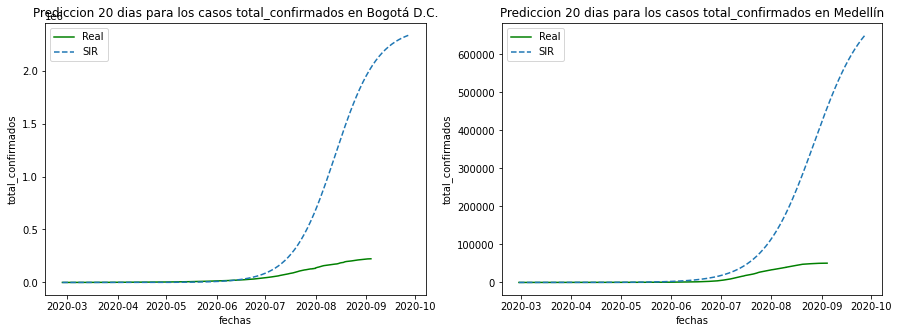

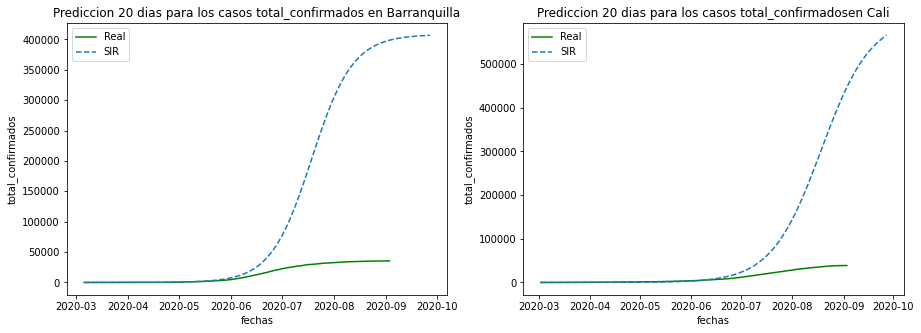

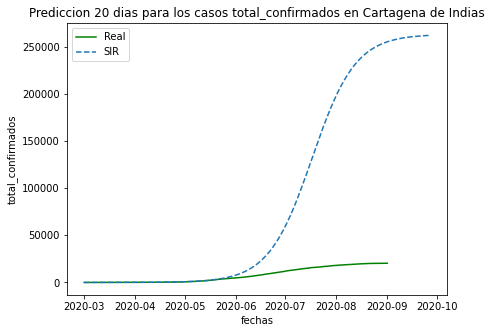

In [48]:
target = 'total_confirmados'
target_sir = 'total_confirmados_sir'

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(bogota[target], 'g-')
ax.plot(bogota_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Bogotá D.C.")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(medellin[target], 'g-')
ax1.plot(medellin_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Medellín")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_confirmados_mb.png')

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(barranquilla[target], 'g-')
ax.plot(barranquilla_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Barranquilla")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(cali[target], 'g-')
ax1.plot(cali_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + "en Cali")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_confirmados_bllcl.png')


fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(cartagena[target], 'g-')
ax.plot(cartagena_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Cartagena de Indias")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_confirmados_c.png')


#### ACTIVOS

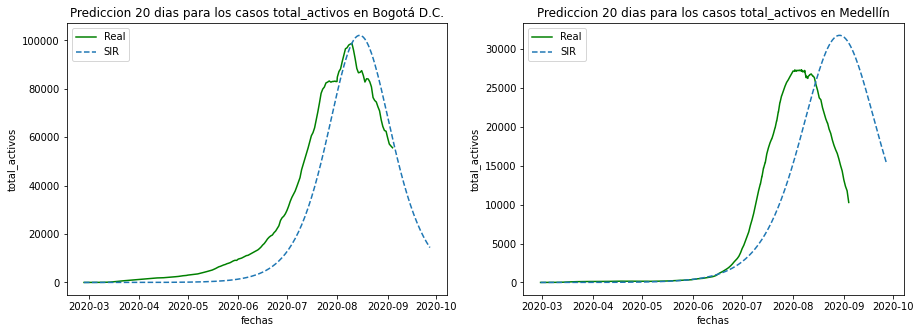

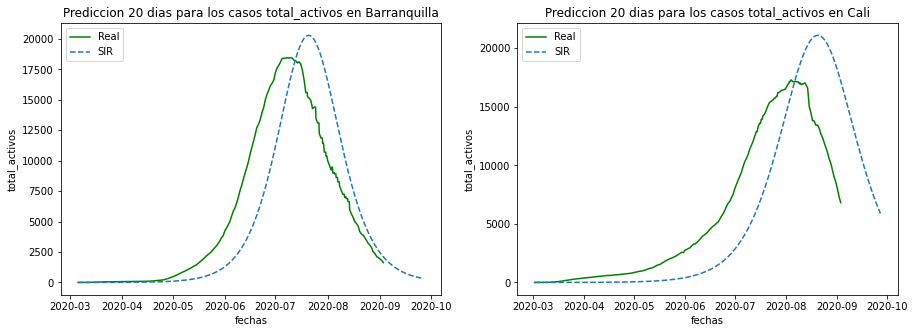

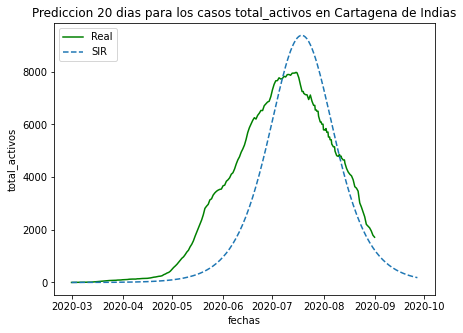

In [49]:
target = 'total_activos'
target_sir = 'total_activos_sir'

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(bogota[target], 'g-')
ax.plot(bogota_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Bogotá D.C.")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(medellin[target], 'g-')
ax1.plot(medellin_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Medellín")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_activos_mb.png')

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(barranquilla[target], 'g-')
ax.plot(barranquilla_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Barranquilla")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(cali[target], 'g-')
ax1.plot(cali_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Cali")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_activos_bllcl.png')


fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(cartagena[target], 'g-')
ax.plot(cartagena_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Cartagena de Indias")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_activos_c.png')

#### RECUPERADOS

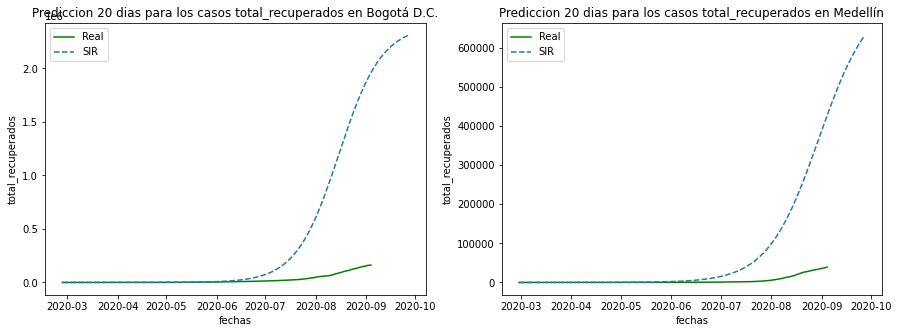

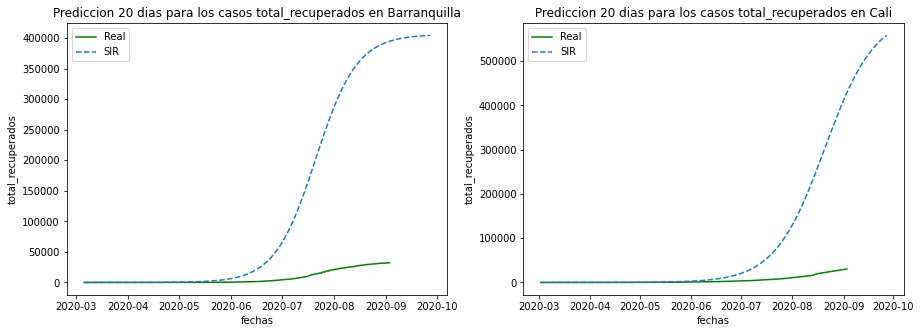

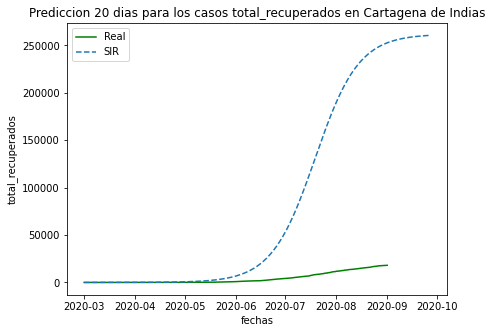

In [50]:
target = 'total_recuperados'
target_sir = 'total_recuperados_sir'

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(bogota[target], 'g-')
ax.plot(bogota_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Bogotá D.C.")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(medellin[target], 'g-')
ax1.plot(medellin_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Medellín")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_recuperados_mb.png')

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(barranquilla[target], 'g-')
ax.plot(barranquilla_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Barranquilla")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(cali[target], 'g-')
ax1.plot(cali_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Cali")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_recuperados_bllcl.png')


fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(cartagena[target], 'g-')
ax.plot(cartagena_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Cartagena de Indias")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_recuperados_c.png')

#### MUERTOS

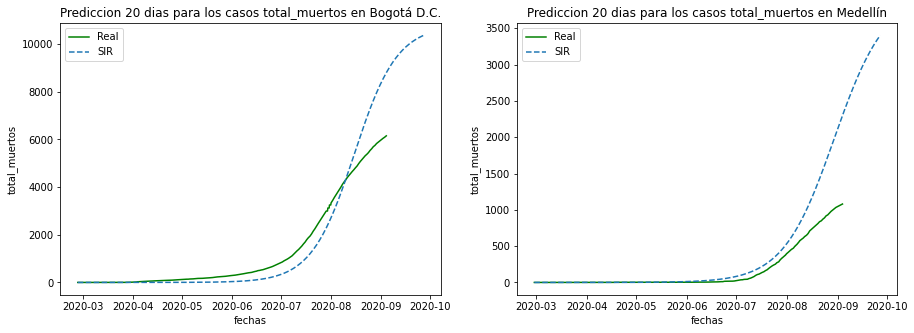

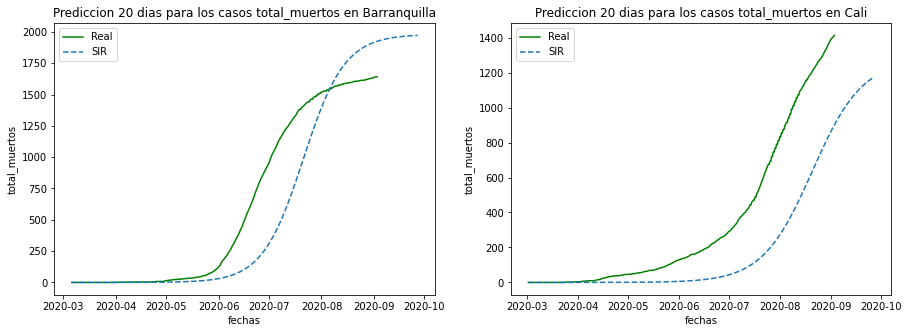

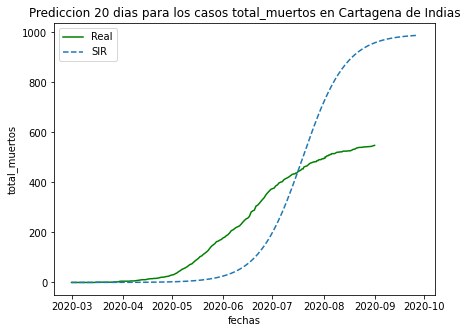

In [51]:
target = 'total_muertos'
target_sir = 'total_muertos_sir'

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(bogota[target], 'g-')
ax.plot(bogota_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Bogotá D.C.")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(medellin[target], 'g-')
ax1.plot(medellin_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Medellín")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_muertos_mb.png')

fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(barranquilla[target], 'g-')
ax.plot(barranquilla_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Barranquilla")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
ax1.plot(cali[target], 'g-')
ax1.plot(cali_sir[target_sir] , '--')
ax1.set_title("Prediccion 20 dias para los casos " + target + " en Cali")
ax1.set_ylabel(target)
ax1.set_xlabel("fechas")
ax1.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_muertos_bllcl.png')


fig=  plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(cartagena[target], 'g-')
ax.plot(cartagena_sir[target_sir], '--')
ax.set_title("Prediccion 20 dias para los casos " + target + " en Cartagena de Indias")
ax.set_ylabel(target)
ax.set_xlabel("fechas")
ax.legend(["Real", "SIR"], loc='upper left')

## Guardar Imagen
fig.savefig('SIR_muertos_c.png')

**CONCLUSIONES MODELO SIR**

Analizando las tasas desde los datos historicos son muy variables en el tiempo , en la implementación de este modelo se usa como una constante lo que hace que la predicción sea un poco alejada de la realidad. Para los casos activos se ve un buen ajuste , debido a que con estso casos sacamos las tasas de contagio y recuperación.